### Import Library

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tensorflow.keras import backend as K

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from keras.wrappers.scikit_learn import KerasRegressor

from scipy.stats import norm, skew
from matplotlib.ticker import FormatStrFormatter

import re
from tqdm import tqdm

In [2]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize':(15,8)},
        style='darkgrid',
       )

### GPU checking

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11530391627379024968
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5767102464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15560899513147540426
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [4]:
"""
print('CUDA GPU availalbe : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')
"""

"\nprint('CUDA GPU availalbe : {}'.format(torch.cuda.is_available()))\ntry:\n    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))\nexcept:\n    print('GPUs are not allocated. Current runtime is on CPU.')\n"

### Import data

In [61]:
data = pd.read_csv("data/data.csv")

In [286]:
data.head()

,OBJECTID_x,ID,pH,As,Cd,Ni,Pb,Zn,Hg,slope,...,HYDGRP_D,ANION_EXCL,SOL_CRK,SOL_K1,CLAY1,SILT1,SAND1,ROCK1,SOL_EC1,distance
0,1,KW-SK-S-36,7.63,17.46,0.480,1.65,91.10,NaN,0.0,36.896198,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,26.743154
1,2,KW-SK-S-37,5.25,1.25,0.050,0.34,58.77,NaN,0.0,28.025801,...,0,0.5,0.5,15.93,15.0,48.0,37.0,28.0,0,26.110083
2,3,KW-SK-S-66,7.72,1.39,0.070,0.59,92.43,NaN,0.0,32.659199,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,27.539522
3,4,KW-SK-CS-03,8.41,6.07,0.105,1.14,2.75,NaN,0.0,27.927500,...,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0,32.448371
4,5,KW-YH-PS-01,8.30,32.70,3.700,1.10,4700.00,NaN,0.0,36.872700,...,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0,7.887498


### Processing missing data & Drop unnecessary data

In [140]:
data.info()

"""
    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)
    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)
    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)
    Ni = 1458/1458 = 100% -> good
    Pb = 757/1458 = 51.9% / 48.1% -> eliminate
    Zn = 337/1458 = 23.1% / 76.9% -> eliminate
    Hg = All 0 
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBJECTID_x      1458 non-null   int64  
 1   ID              1458 non-null   object 
 2   pH              1458 non-null   float64
 3   As              1458 non-null   float64
 4   Cd              1458 non-null   float64
 5   Ni              1458 non-null   float64
 6   Pb              757 non-null    float64
 7   Zn              337 non-null    object 
 8   Hg              1458 non-null   float64
 9   slope           1458 non-null   float64
 10  altitude        1458 non-null   float64
 11  profile_curve   1458 non-null   float64
 12  profile_c_num   1458 non-null   float64
 13  profile_c_abs   1458 non-null   int64  
 14  planform_curve  1458 non-null   float64
 15  planform_c_num  1458 non-null   float64
 16  planform_c_abs  1458 non-null   int64  
 17  HYDGRP          1458 non-null   o

'\n    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)\n    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)\n    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)\n    Ni = 1458/1458 = 100% -> good\n    Pb = 757/1458 = 51.9% / 48.1% -> eliminate\n    Zn = 337/1458 = 23.1% / 76.9% -> eliminate\n    Hg = All 0 \n'

<AxesSubplot:>

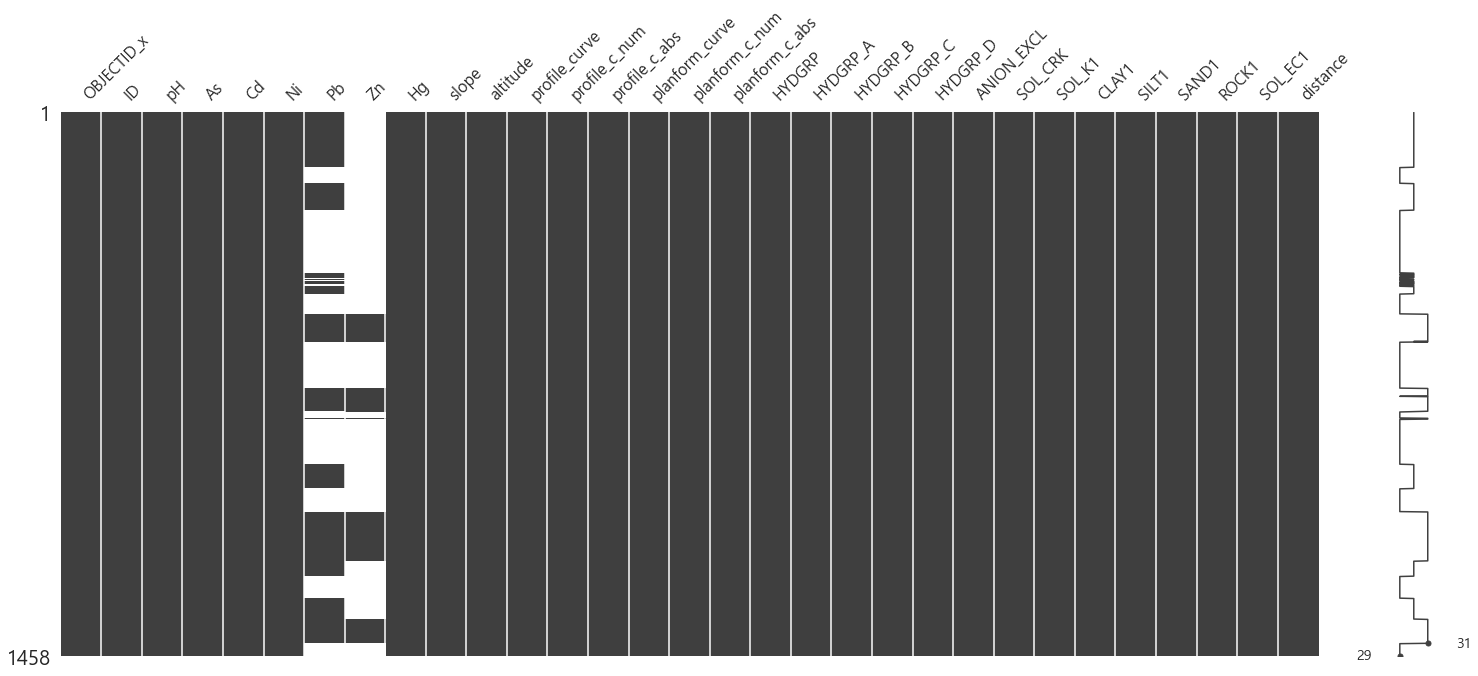

In [621]:
msno.matrix(data)

In [62]:
data = data.drop(['ID'], axis = 1)

# pd.get_dummies X, Negative data to 0, Postive data to 1
data = data.drop(['HYDGRP','profile_curve','planform_curve','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)

### train / test split & eliminate outlier

In [63]:
def eli_outlier(data, value):
        q1 = data[value].quantile(0.25)
        q3 = data[value].quantile(0.75)
        
        iqr = q3 - q1
        
        q1_condition = data[value] < q1-1.5*iqr
        q3_condition = data[value] > q3+1.5*iqr
        
        reset_q1_index = data[q1_condition].index
        reset_q3_index = data[q3_condition].index
        
        data.drop(reset_q1_index, inplace = True)
        data.drop(reset_q3_index, inplace = True)        

In [64]:
train, test = train_test_split(data, test_size=0.2, random_state=605)

In [65]:
# pd.get_dummies X, Negative data to 0, Postive data to 1
# train

As_train = train.drop(['OBJECTID_x','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_train = train.drop(['OBJECTID_x','As','Ni','Pb','Zn','Hg'], axis=1)
Ni_train = train.drop(['OBJECTID_x','As','Cd','Pb','Zn','Hg'], axis=1)
Pb_train = train.drop(['OBJECTID_x','As','Cd','Ni','Zn','Hg'], axis=1)
Zn_train = train.drop(['OBJECTID_x','As','Cd','Ni','Pb','Hg'], axis=1)

eli_outlier(As_train, 'As')
eli_outlier(Cd_train, 'Cd')
eli_outlier(Ni_train, 'Ni')

In [66]:
# test

As_test = test
Cd_test = test
Ni_test = test

eli_outlier(As_test, 'As')
eli_outlier(Cd_test, 'Cd')
eli_outlier(Ni_test, 'Ni')

As_test = As_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_test = Cd_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Ni_test = Ni_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)

In [67]:
As_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031 entries, 670 to 1162
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              1031 non-null   float64
 1   As              1031 non-null   float64
 2   slope           1031 non-null   float64
 3   altitude        1031 non-null   float64
 4   profile_c_num   1031 non-null   float64
 5   profile_c_abs   1031 non-null   int64  
 6   planform_c_num  1031 non-null   float64
 7   planform_c_abs  1031 non-null   int64  
 8   HYDGRP_A        1031 non-null   int64  
 9   HYDGRP_B        1031 non-null   int64  
 10  HYDGRP_C        1031 non-null   int64  
 11  HYDGRP_D        1031 non-null   int64  
 12  SOL_K1          1031 non-null   float64
 13  CLAY1           1031 non-null   float64
 14  SILT1           1031 non-null   float64
 15  SAND1           1031 non-null   float64
 16  ROCK1           1031 non-null   float64
 17  distance        1031 non-null  

In [68]:
As_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 960 to 353
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              225 non-null    float64
 1   slope           225 non-null    float64
 2   altitude        225 non-null    float64
 3   profile_c_num   225 non-null    float64
 4   profile_c_abs   225 non-null    int64  
 5   planform_c_num  225 non-null    float64
 6   planform_c_abs  225 non-null    int64  
 7   HYDGRP_A        225 non-null    int64  
 8   HYDGRP_B        225 non-null    int64  
 9   HYDGRP_C        225 non-null    int64  
 10  HYDGRP_D        225 non-null    int64  
 11  SOL_K1          225 non-null    float64
 12  CLAY1           225 non-null    float64
 13  SILT1           225 non-null    float64
 14  SAND1           225 non-null    float64
 15  ROCK1           225 non-null    float64
 16  distance        225 non-null    float64
dtypes: float64(11), int64(6)
memory u

### Check the value skewed

#### As

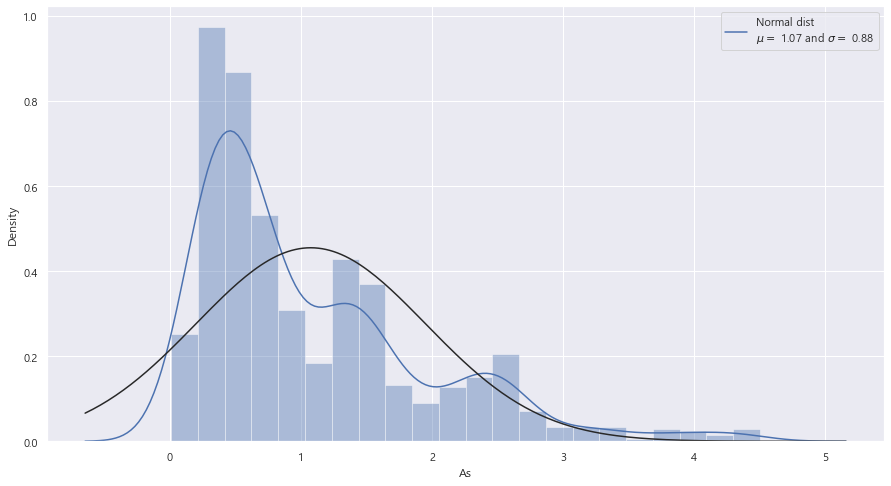

In [629]:
sns.distplot(As_train.As, fit = norm)
(mu, sigma) = norm.fit(As_train['As'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

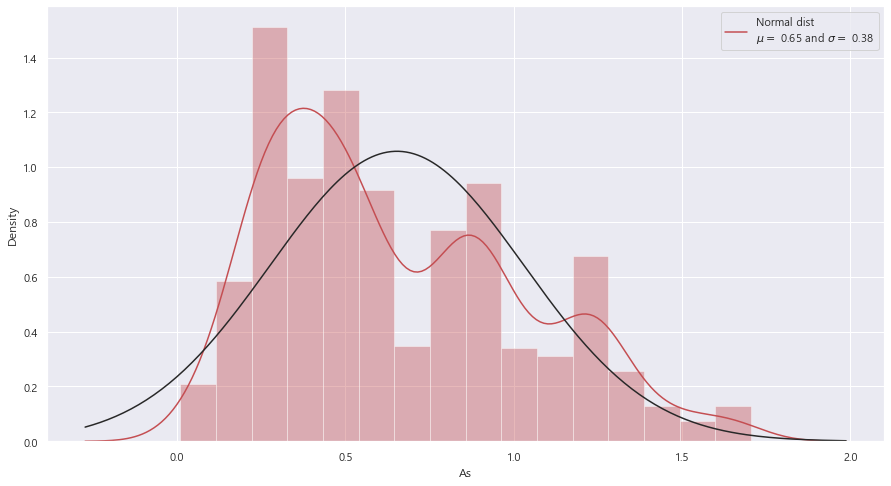

In [630]:
# 로그변환

sns.distplot(np.log1p(As_train.As), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(As_train['As']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Cd

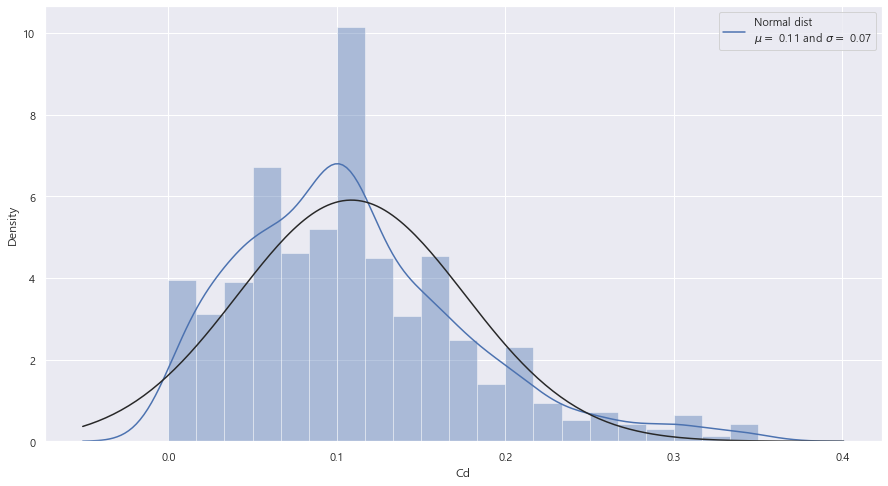

In [631]:
sns.distplot(Cd_train.Cd, fit = norm)
(mu, sigma) = norm.fit(Cd_train['Cd'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

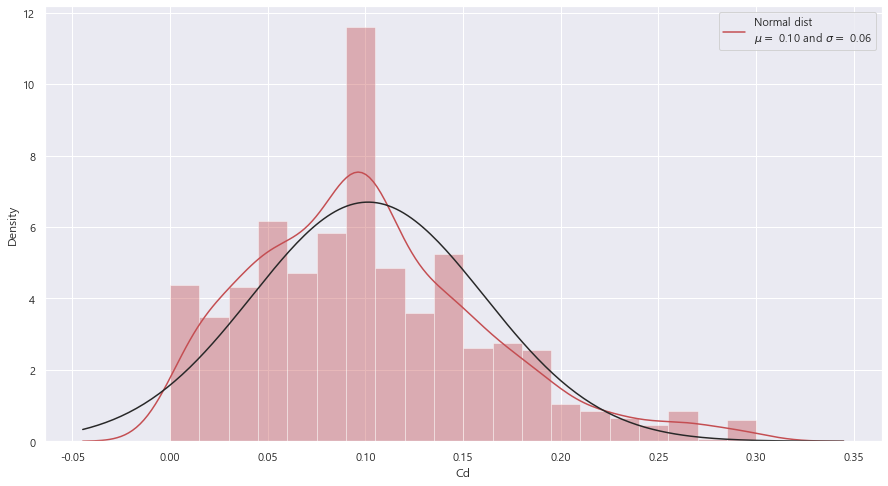

In [632]:
# 로그변환

sns.distplot(np.log1p(Cd_train.Cd), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Cd_train['Cd']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Ni

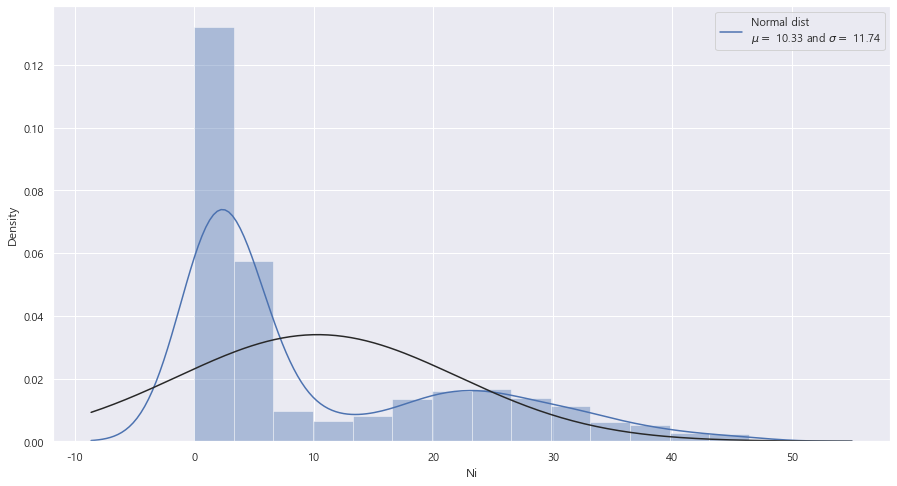

In [633]:
sns.distplot(Ni_train.Ni, fit = norm)
(mu, sigma) = norm.fit(Ni_train['Ni'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

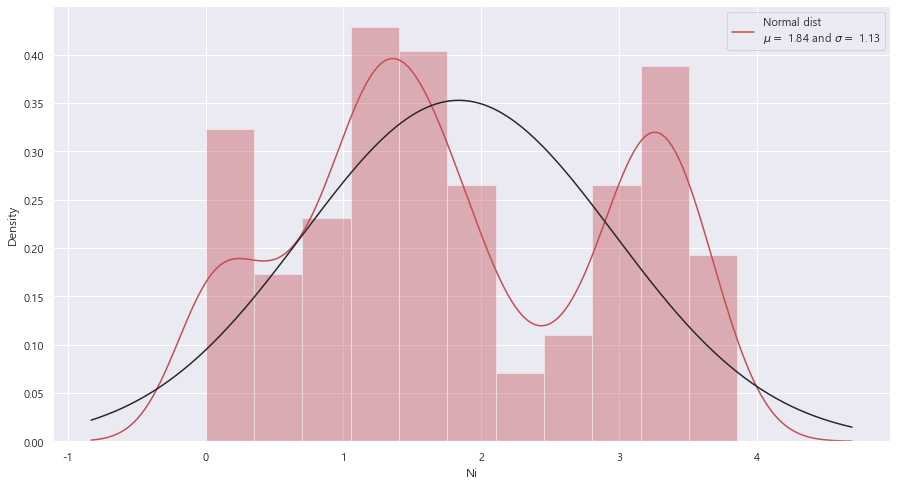

In [634]:
# 로그변환

sns.distplot(np.log1p(Ni_train.Ni), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Ni_train['Ni']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Log-Transformation

In [69]:
As_train.As = np.log1p(As_train.As)
Cd_train.Cd = np.log1p(Cd_train.Cd)
Ni_train.Ni = np.log1p(Ni_train.Ni)

'\nAs_train.altitude = np.log1p(As_train.altitude)\nCd_train.altitude = np.log1p(Cd_train.altitude)\nNi_train.altitude = np.log1p(Ni_train.altitude)\n\nAs_train.slope = np.log1p(As_train.slope)\nCd_train.slope = np.log1p(Cd_train.slope)\nNi_train.slope = np.log1p(Ni_train.slope)\n'

In [70]:
As_test_index = As_test.index
Cd_test_index = Cd_test.index
Ni_test_index = Ni_test.index

In [71]:
As_train_index = As_train.index
Cd_train_index = Cd_train.index
Ni_train_index = Ni_train.index

#### Scaling

In [72]:
As_X = As_train.drop('As', axis=1)
As_y = As_train.As

Cd_X = Cd_train.drop('Cd', axis=1)
Cd_y = Cd_train.Cd

Ni_X = Ni_train.drop('Ni', axis=1)
Ni_y = Ni_train.Ni

In [73]:
scaler = StandardScaler()

scaler.fit(As_X)
As_X = pd.DataFrame(scaler.transform(As_X), columns=As_X.columns)
As_test = pd.DataFrame(scaler.transform(As_test), columns=As_test.columns)

scaler.fit(Cd_X)
Cd_X = pd.DataFrame(scaler.transform(Cd_X), columns=Cd_X.columns)
Cd_test = pd.DataFrame(scaler.transform(Cd_test), columns=Cd_test.columns)

scaler.fit(Ni_X)
Ni_X = pd.DataFrame(scaler.transform(Ni_X), columns=Ni_X.columns)
Ni_test = pd.DataFrame(scaler.transform(Ni_test), columns=Ni_test.columns)


#### Define Hyperparameter

In [22]:
# dense_nparams_n : n-dense layer size
dense_nparams_1 = [64, 256]
dense_nparams_2 = [512, 2048]
dense_nparams_3 = [64, 256]

"""# dense_layer_sizes : dense layer size list
dense_layer_sizes = [(64, 512, 64, ), (256, 2048, 256, )]"""

"""# input_optimizer : using optimizer
input_optimizer = [SGD, Adagrad, RMSprop, Adam, Adamax]"""

"""# input_kernel_initializer : to initialize weights
input_kernel_initializer = ['uniform', 'normal', 
                            'glorot_uniform', 'glorot_normal',
                            'he_uniform', 'he_normal' ]"""

"""# kernel_regularizer_weight_decay : regularizer weight decay list
kernel_regularizer_weight_decay = [0.01, 0.001, 0.0001]"""


"""# input_dropout : dropout ratio
input_dropout = [0, 0.1, 0.2, 0.3, 0.4, 0.5]"""

# input_lr : learning_rate
input_lr = [0.1, 0.01, 0.001]

# batch_size : batch_size
batch_size = [64, 128, 256]

# epochs : epochs
epochs = [50, 100]

# optimizers: optimizers
optimizers = [Adam, RMSprop]

# hyperparameter dict
param_grid = dict(dense_nparams_1 = dense_nparams_1,
                  dense_nparams_2 = dense_nparams_2,
                  dense_nparams_3 = dense_nparams_3,
                  input_lr = input_lr)

val_param_grid = dict(batch_size = batch_size,
                    epochs = epochs,
                    optimizers = optimizers)

# Bayesian hyperparmeter dict
bay_pbounds = {
    'dense_nparams' : (64, 256),
    'dense_layer_sizes' : (64, 256),
    'input_dropout' : (0.01, 0.05),
    'kernel_regularizer_weight_decay' : (0.001, 0.1),
    'input_lr' : (0.001, 0.1)
}

In [20]:
def create_simpleDNN(dense_nparams_1, dense_nparams_2, dense_nparams_3, input_lr):
    model = Sequential()
    model.add(Dense(dense_nparams_1, activation='relu', input_shape=(As_X.shape[1],),
                    kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(dense_nparams_2, activation='relu', input_shape=(As_X.shape[1],),
                    kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(dense_nparams_3, activation='relu', input_shape=(As_X.shape[1],),
                    kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    
    optimizer = Adam(lr = input_lr)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    return model

In [31]:
def val_simpleDNN(optimizers):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(Ni_X.shape[1],),
                    kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dropout(0.3)),
    model.add(Dense(2048, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dropout(0.3)),
    model.add(Dense(64, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dropout(0.3)),
    model.add(Dense(1))
    
    optimizers = optimizers(lr = 0.001)
    
    model.compile(optimizer=optimizers, loss='mse', metrics=['mse'])
    
    return model
    

In [21]:
regressor_model = KerasRegressor(build_fn=create_simpleDNN, epochs=300,
                                 batch_size = 10, verbose = 0)

val_regressor_model = KerasRegressor(build_fn=val_simpleDNN)

In [16]:
# sequential model 1 (use in bayesian optimization)

"""def create_simpleDNN(dense_nparams, dense_layer_sizes, input_dropout, kernel_regularizer_weight_decay, input_dropout, input_lr):
    
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(As_X.shape[1],),
                    kernel_regularizer=keras.regularizers.l2(kernel_regularizer_weight_decay),
                    kernel_initializer=input_kernel_initializer))
    model.add(Dropout(input_dropout),)
    
    for layer_size in dense_layer_sizes:
        model.add(Dense(layer_size, activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(kernel_regularizer_weight_decay),
                        kernel_initializer=input_kernel_initializer))
        model.add(Dropout(input_dropout), )
    
    model.add(Dense(1))
    
    optimizer = input_optimizer(lr = input_lr)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    return model"""

#### GridSearchCV & Bayesian optimization

In [24]:
# RMSE custom metric

def rmse(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    return rmse

In [25]:
kf = KFold(random_state=605,
           n_splits=2,
           shuffle=True)

grid = GridSearchCV(estimator=regressor_model,
                    param_grid=param_grid,
                    scoring=make_scorer(rmse, greater_is_better=False),
                    cv=kf,
                    n_jobs=1,
                    verbose=3)

val_grid = GridSearchCV(estimator=val_regressor_model,
                        param_grid=val_param_grid,
                        scoring=make_scorer(rmse, greater_is_better=False),
                        cv=kf,
                        n_jobs=1,
                        verbose=3)

In [32]:
As_grid_result = grid.fit(As_X, As_y)

# As gridesearch 결과
print("최고의 파라미터 :", As_grid_result.best_params_)
print("최고 RMSE : {}".format(As_grid_result.best_score_))

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV 1/2] END dense_nparams_1=64, dense_nparams_2=512, dense_nparams_3=64, input_lr=0.1;, score=-0.374 total time=  43.3s
[CV 2/2] END dense_nparams_1=64, dense_nparams_2=512, dense_nparams_3=64, input_lr=0.1;, score=-0.393 total time=  41.0s
[CV 1/2] END dense_nparams_1=64, dense_nparams_2=512, dense_nparams_3=64, input_lr=0.01;, score=-0.370 total time=  41.1s
[CV 2/2] END dense_nparams_1=64, dense_nparams_2=512, dense_nparams_3=64, input_lr=0.01;, score=-0.386 total time=  41.9s
[CV 1/2] END dense_nparams_1=64, dense_nparams_2=512, dense_nparams_3=64, input_lr=0.001;, score=-0.377 total time=  43.8s
[CV 2/2] END dense_nparams_1=64, dense_nparams_2=512, dense_nparams_3=64, input_lr=0.001;, score=-0.374 total time=  43.3s
[CV 1/2] END dense_nparams_1=64, dense_nparams_2=512, dense_nparams_3=256, input_lr=0.1;, score=-0.370 total time=  41.7s
[CV 2/2] END dense_nparams_1=64, dense_nparams_2=512, dense_nparams_3=256, input_lr=0

In [ ]:
Cd_grid_result = grid.fit(Cd_X, Cd_y)

# Cd gridesearch 결과
print("최고의 파라미터 :", Cd_grid_result.best_params_)
print("최고 RMSE : {}".format(Cd_grid_result.best_score_))

In [ ]:
Ni_grid_result = grid.fit(Ni_X, Ni_y)

# Ni gridesearch 결과
print("최고의 파라미터 :", Ni_grid_result.best_params_)
print("최고 RMSE : {}".format(Ni_grid_result.best_score_))

In [ ]:
from bayes_opt import BayesianOptimization

boDNN=BayesianOptimization(f=regressor_model, pbounds=bay_pbounds, verbose=2, random_state=605) 

In [ ]:
boDNN.maximize(init_points=2, n_iter=10, acq='ei', xi=0.01)

print("최고의 파라미터 : ", boDNN.max)

### DNN model

In [74]:
def simpleDNN(train):
    weight_decay = 0.01
    learning_rate = 0.001

    # structure :
    
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(train.shape[1],), 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(2048, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)
    ])
    
    return model, learning_rate

#### Custom Metrics

In [75]:
def r_2_score(y_true, y_pred):
    SSR =  K.sum(K.square(y_true- y_pred))
    SSE = K.sum(K.square(y_pred - K.mean(y_true)))
    SST = SSE+SSR
    
    return SSE/SST

#### AS

In [48]:
model, eta = simpleDNN(As_X)

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=eta), 
              loss='mse', metrics=['mse'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=30, restore_best_weights=True)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=10, verbose=0, mode='auto', 
                                                 min_delta=0.0001, cooldown=0, min_lr=0)

"early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', \n                                               patience=30, restore_best_weights=True)\n\nlr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, \n                                                 patience=10, verbose=0, mode='auto', \n                                                 min_delta=0.0001, cooldown=0, min_lr=0)"

In [49]:
As_history = model.fit(As_X, As_y, validation_split=0.1, 
                        epochs=1000, batch_size=256, callbacks=[early_stopping, lr_scheduler], 
                        verbose=0)

"""As_history = model.fit(As_X, As_y, validation_split=0.1, 
                        epochs=1000, batch_size=256, verbose=1)"""

Epoch 1/1000
4/4 [==============================] - 1s 57ms/step - loss: 11.0033 - mse: 8.2400 - val_loss: 3.3329 - val_mse: 0.5600
Epoch 2/1000
4/4 [==============================] - 0s 19ms/step - loss: 4.8698 - mse: 2.1030 - val_loss: 3.2156 - val_mse: 0.4604
Epoch 3/1000
4/4 [==============================] - 0s 19ms/step - loss: 4.4707 - mse: 1.7223 - val_loss: 3.3735 - val_mse: 0.6376
Epoch 4/1000
4/4 [==============================] - 0s 20ms/step - loss: 4.5989 - mse: 1.8690 - val_loss: 3.3138 - val_mse: 0.5960
Epoch 5/1000
4/4 [==============================] - 0s 20ms/step - loss: 4.2640 - mse: 1.5533 - val_loss: 3.2576 - val_mse: 0.5608
Epoch 6/1000
4/4 [==============================] - 0s 21ms/step - loss: 4.3863 - mse: 1.6972 - val_loss: 3.1862 - val_mse: 0.5097
Epoch 7/1000
4/4 [==============================] - 0s 20ms/step - loss: 4.0759 - mse: 1.4071 - val_loss: 3.2298 - val_mse: 0.5747
Epoch 8/1000
4/4 [==============================] - 0s 21ms/step - loss: 4.0617 - 

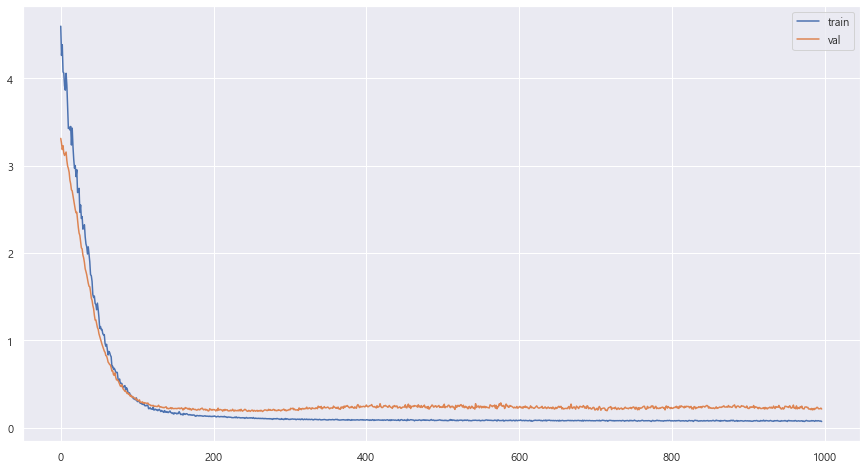

0.22070257365703583


In [50]:
plt.plot(As_history.history['loss'][3:], label='train')
plt.plot(As_history.history['val_loss'][3:], label='val')
plt.legend()
plt.show()
print(As_history.history['val_loss'][-30])

In [51]:
# predict
As_pred = model.predict(As_test)

# reverse log scailing
As_pred = np.expm1(As_pred)

#### Cd

In [76]:
model, eta = simpleDNN(Cd_X)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), 
              loss='mse', metrics=['mse'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=30, restore_best_weights=True)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=10, verbose=0, mode='auto', 
                                                 min_delta=0.0001, cooldown=0, min_lr=0)

In [77]:
Cd_history = model.fit(Cd_X, Cd_y, validation_split=0.1, 
                        epochs=1000, batch_size=256, callbacks=[early_stopping, lr_scheduler], verbose=1)

Epoch 1/1000
4/4 [==============================] - 1s 51ms/step - loss: 5.4533 - mse: 2.6955 - val_loss: 2.7844 - val_mse: 0.0263
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.5643 - mse: 1.8063 - val_loss: 2.7640 - val_mse: 0.0065
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.4097 - mse: 1.6531 - val_loss: 2.7604 - val_mse: 0.0063
Epoch 4/1000
4/4 [==============================] - 0s 15ms/step - loss: 4.1713 - mse: 1.4191 - val_loss: 2.7551 - val_mse: 0.0076
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.0465 - mse: 1.3020 - val_loss: 2.7460 - val_mse: 0.0080
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.7625 - mse: 1.0284 - val_loss: 2.7370 - val_mse: 0.0114
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.6770 - mse: 0.9563 - val_loss: 2.7184 - val_mse: 0.0080
Epoch 8/1000
4/4 [==============================] - 0s 15ms/step - loss: 3.6219 - m

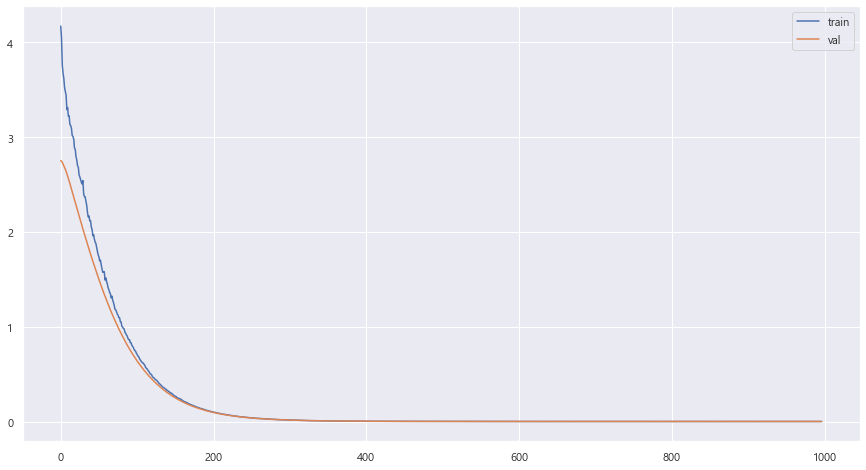

0.004317891784012318


In [78]:
plt.plot(Cd_history.history['loss'][3:], label='train')
plt.plot(Cd_history.history['val_loss'][3:], label='val')
plt.legend()
plt.show()
print(Cd_history.history['val_loss'][-30])

In [79]:
# predict
Cd_pred = model.predict(Cd_test)

# reverse log scailing
Cd_pred = np.expm1(Cd_pred)

#### Ni

In [80]:
model, eta = simpleDNN(Ni_X)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), 
              loss='mse', metrics=['mse'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=30, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=10, verbose=0, mode='auto', 
                                                 min_delta=0.0001, cooldown=0, min_lr=0)

"early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', \n                                               patience=30, restore_best_weights=True)\nlr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, \n                                                 patience=10, verbose=0, mode='auto', \n                                                 min_delta=0.0001, cooldown=0, min_lr=0)"

In [81]:
Ni_history = model.fit(Ni_X, Ni_y, validation_split=0.1, 
                        epochs=1000, batch_size=256, callbacks=[early_stopping, lr_scheduler], verbose=1)

Epoch 1/1000
4/4 [==============================] - 1s 49ms/step - loss: 9.5608 - mse: 6.8055 - val_loss: 7.8280 - val_mse: 5.0713
Epoch 2/1000
4/4 [==============================] - 0s 11ms/step - loss: 8.5068 - mse: 5.7492 - val_loss: 7.7661 - val_mse: 5.0076
Epoch 3/1000
4/4 [==============================] - 0s 11ms/step - loss: 8.3052 - mse: 5.5467 - val_loss: 7.7747 - val_mse: 5.0166
Epoch 4/1000
4/4 [==============================] - 0s 12ms/step - loss: 7.6402 - mse: 4.8832 - val_loss: 7.7108 - val_mse: 4.9561
Epoch 5/1000
4/4 [==============================] - 0s 11ms/step - loss: 7.4597 - mse: 4.7071 - val_loss: 7.5290 - val_mse: 4.7805
Epoch 6/1000
4/4 [==============================] - 0s 11ms/step - loss: 7.4704 - mse: 4.7250 - val_loss: 7.4393 - val_mse: 4.6996
Epoch 7/1000
4/4 [==============================] - 0s 11ms/step - loss: 6.9760 - mse: 4.2403 - val_loss: 7.4223 - val_mse: 4.6937
Epoch 8/1000
4/4 [==============================] - 0s 11ms/step - loss: 6.7831 - m

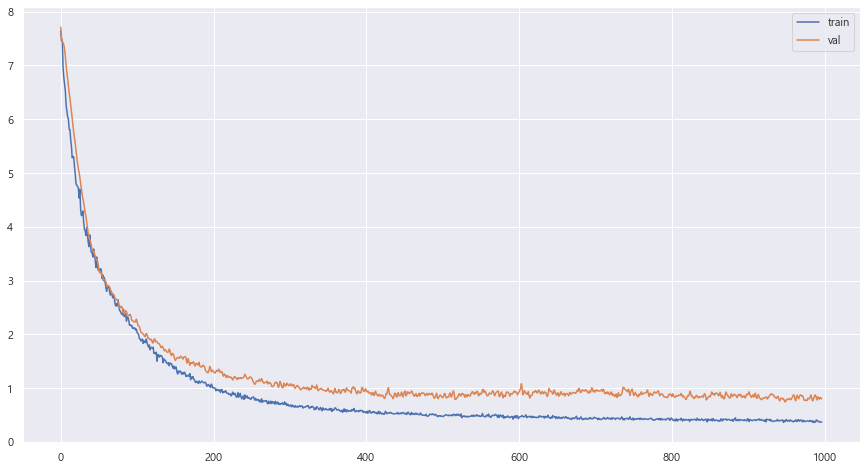

0.8480305671691895


In [82]:
plt.plot(Ni_history.history['loss'][3:], label='train')
plt.plot(Ni_history.history['val_loss'][3:], label='val')
plt.legend()
plt.show()
print(Ni_history.history['val_loss'][-30])

In [83]:
# test predict
Ni_pred = model.predict(Ni_test)

# reverse log scailing
Ni_pred = np.expm1(Ni_pred)

### Evaluate Model

In [84]:
As_test = pd.DataFrame()
Cd_test = pd.DataFrame()
Ni_test = pd.DataFrame()

As_test['index'] = As_test_index
Cd_test['index'] = Cd_test_index
Ni_test['index'] = Ni_test_index

for index in As_test['index']:
    As_test.loc[As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    
for index in Cd_test['index']:
    Cd_test.loc[Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']

for index in Ni_test['index']:
    Ni_test.loc[As_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']

In [85]:
def SST(data, pred):
    sst = 0
    
    for i in range(0, len(pred)):
        sst += ((data[i] - np.mean(data))**2)
        
    return sst

def SSE(data, pred):
    sse = 0
    
    for i in range(0, len(pred)):
        sse += ((pred[i] - np.mean(data))**2)
        
    return sse

def SSR(data, pred):
    ssr = 0
    
    for i in range(0, len(data)):
        ssr += ((data[i] - pred[i])**2)
    
    return ssr

#### r2 scoring

In [86]:
def cal_train_r2(pred, value):
    test = pd.DataFrame()
    test['real_value'] = np.array(value)
    test['value'] = pred


    sse = SSE(test['real_value'], test['value'])
    ssr = SSR(test['real_value'], test['value'])
    sst = SST(test['real_value'], test['value'])
    
    test_r2 = sse/sst
    print(f'r2 score : {test_r2}')

In [87]:
cal_train_r2(As_pred, As_test['As_real_value'])
cal_train_r2(Cd_pred, Cd_test['Cd_real_value'])
cal_train_r2(Ni_pred, Ni_test['Ni_real_value'])

r2 score : 0.5227408218546079
r2 score : 0.21357429168598063
r2 score : 0.8485046251269478


#### rmse scoring

In [88]:
def cal_rmse(pred, value):
    test = pd.DataFrame()
    test['real_value'] = np.array(value)
    test['value'] = pred

    rmse = np.sqrt(mean_squared_error(test['real_value'], test['value']))
    print(f'rmse : {rmse}')

In [89]:
cal_rmse(As_pred, As_test['As_real_value'])
cal_rmse(Cd_pred, Cd_test['Cd_real_value'])
cal_rmse(Ni_pred, Ni_test['Ni_real_value'])

rmse : 0.8291717359251315
rmse : 0.059981034703382195
rmse : 7.1552024063709565


### Visualization

In [97]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize':(15,14)},
        style='darkgrid',
       )

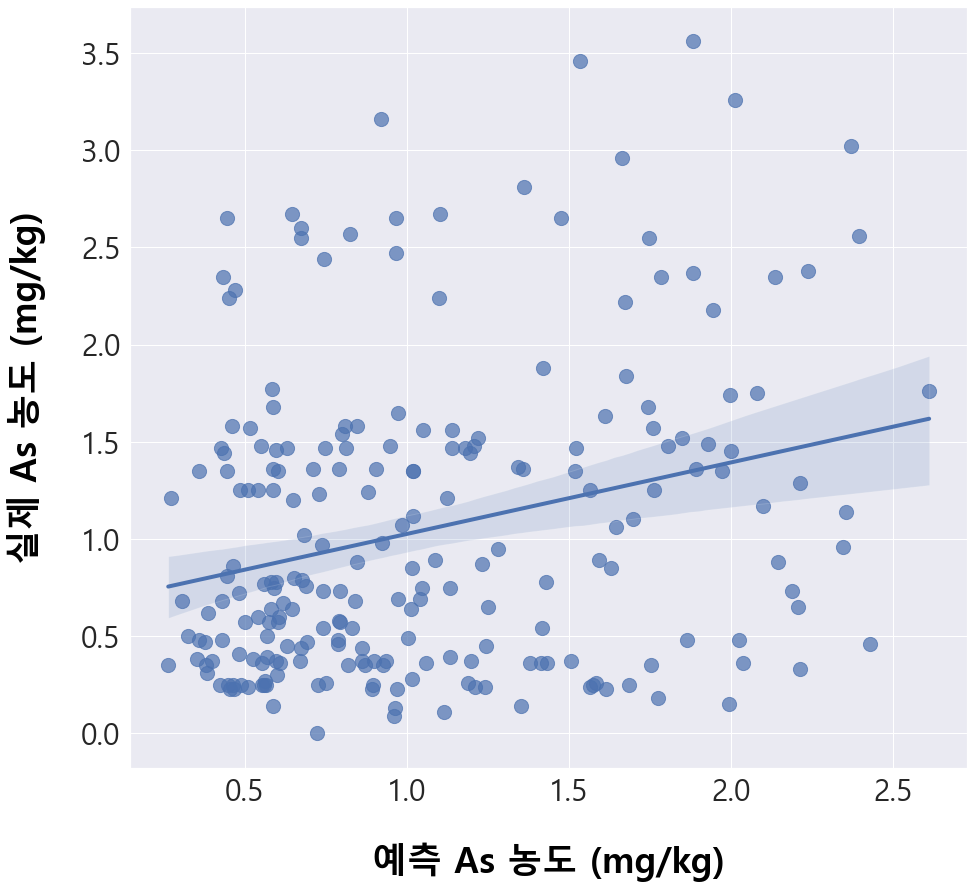

In [102]:
#plt.title('DNN을 이용하여 예측한 As의 선형 그래프', fontdict={'color': 'black', 'weight': 'bold', 'size': 25}, pad=40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
#plt.scatter(As_pred, As_test['As_real_value'], marker='D', alpha=0.5)
sns.regplot(As_pred, As_test['As_real_value'], scatter_kws={'s': 200, 'alpha': 0.7}, line_kws={'linewidth':4})
plt.xlabel('예측 As 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.ylabel('실제 As 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.show()

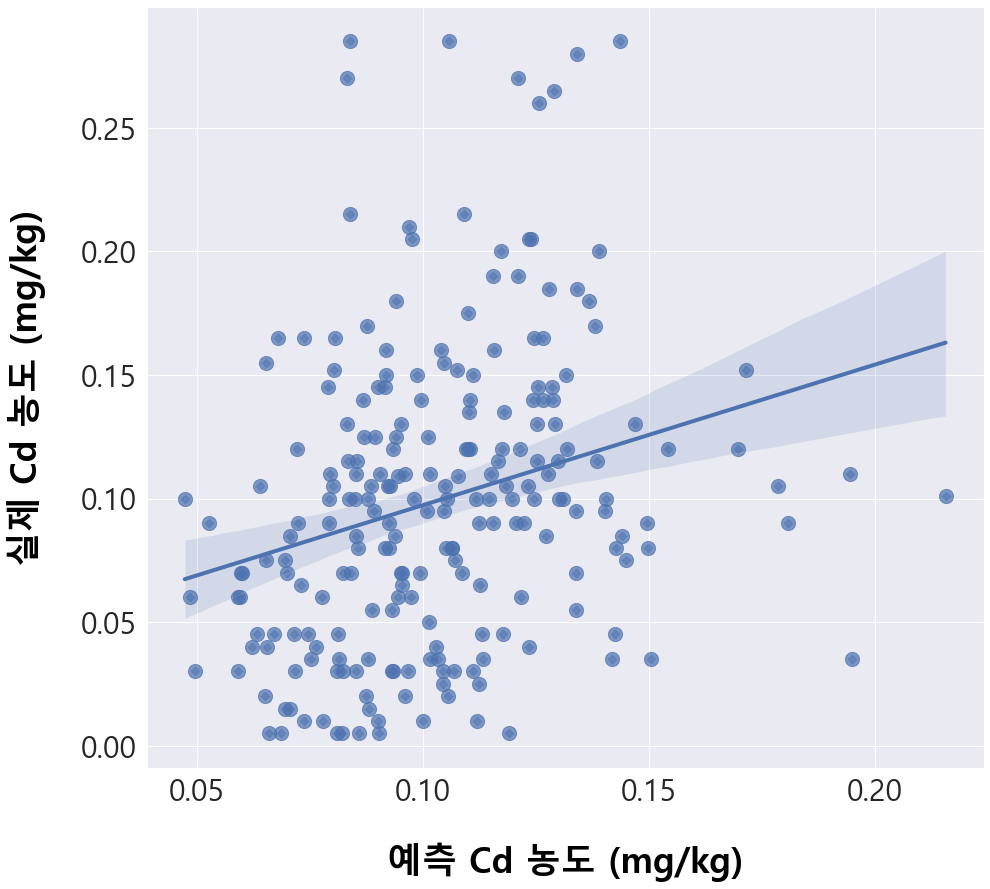

In [108]:
#plt.title('DNN을 이용하여 예측한 Cd의 선형 그래프', fontdict={'color': 'black', 'weight': 'bold', 'size': 25}, pad=40)
plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3], fontsize = 30)
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], fontsize = 30)
plt.scatter(Cd_pred, Cd_test['Cd_real_value'], marker='D', alpha=0.5)
sns.regplot(Cd_pred, Cd_test['Cd_real_value'], scatter_kws={'s': 200, 'alpha': 0.7}, line_kws={'linewidth':4})
plt.xlabel('예측 Cd 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.ylabel('실제 Cd 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.show()

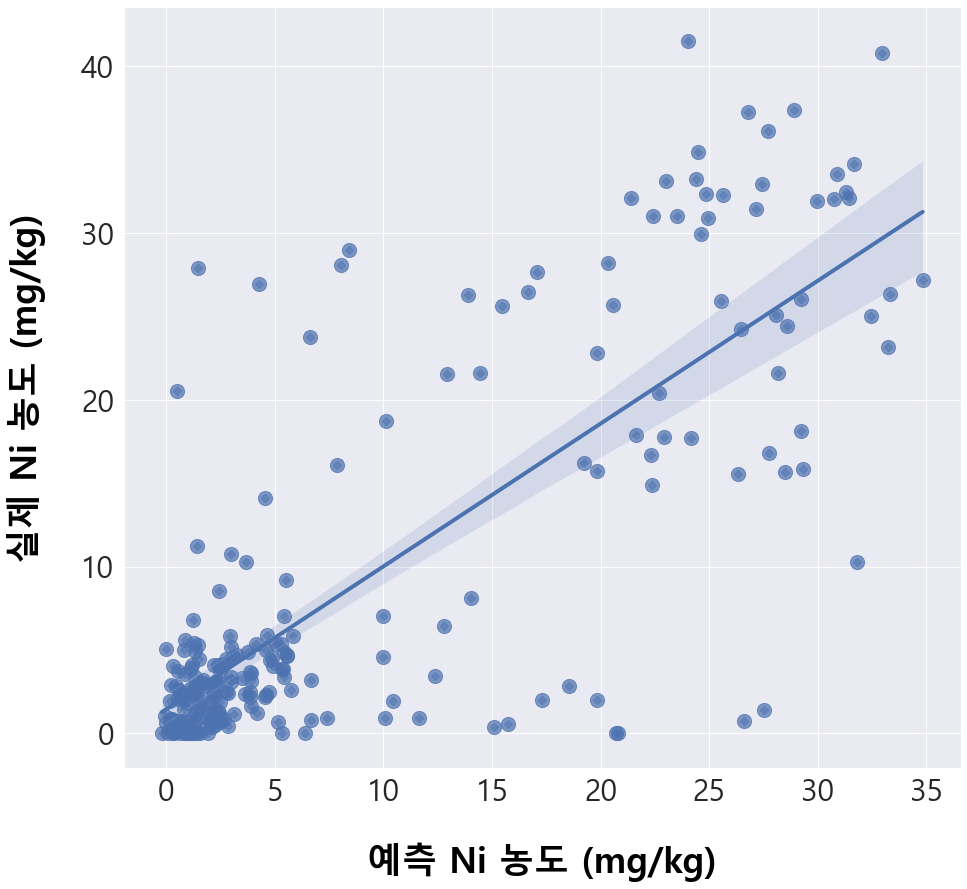

In [104]:
#plt.title('DNN을 이용하여 예측한 Ni의 선형 그래프', fontdict={'color': 'black', 'weight': 'bold', 'size': 25}, pad=40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.scatter(Ni_pred, Ni_test['Ni_real_value'], marker='D', alpha=0.5)
sns.regplot(Ni_pred, Ni_test['Ni_real_value'], scatter_kws={'s': 200, 'alpha': 0.7}, line_kws={'linewidth':4})
plt.xlabel('예측 Ni 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.ylabel('실제 Ni 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.show()